# Setup

In [1]:
from __future__ import print_function
import numpy as np
import keras
import keras.datasets.cifar10
from tqdm import trange
import matplotlib.pyplot as plt
np.random.seed(20191220)

2024-06-23 19:40:03.619023: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Classes and Functions

In [34]:
class Layer:
    def __init__(self):
        self.weights = np.zeros(shape=(input.shape[1], 10))
        bias = np.zeros(shape=(10,))
        pass
    
    def forward(self, input):
        output = np.matmul(input, self.weights) + bias
        return output

class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate = 0.1):
        self.learning_rate = learning_rate
        self.weights = np.random.randn(input_units, output_units) * 0.01
        self.biases = np.zeros(output_units)
        
    def forward(self,input):
        return np.matmul(input, self.weights) + self.biases
      
    def backward(self, input, gradient_output):
        gradient_input = np.dot(gradient_output, np.transpose(self.weights))
        gradient_weights = np.transpose(np.dot(np.transpose(gradient_output), input))
        gradient_biases = np.sum(gradient_output, axis = 0)
        self.weights = self.weights - self.learning_rate * gradient_weights
        self.biases = self.biases - self.learning_rate * gradient_biases
        return gradient_input

class ReLU(Layer):
    def __init__(self):
        pass
    
    def forward(self, input):
        return np.maximum(0, input)

    def backward(self, input, gradient_output):
        relu_gradient = input > 0
        return gradient_output * relu_gradient 

def softmafeatures_crossentropvalues_with_logits(logits, reference_answers):
    logits_for_answers = logits[np.arange(len(logits)), reference_answers]
    featuresentropy = - logits_for_answers + np.log(np.sum(np.exp(logits), axis = -1))
    return featuresentropy

def gradient_softmafeatures_crossentropvalues_with_logits(logits, reference_answers):
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)),reference_answers] = 1
    softmafeatures = np.exp(logits) / np.exp(logits).sum(axis = -1, keepdims = True)
    return (- ones_for_answers + softmafeatures) / logits.shape[0]

def forward(artificial_neural_network, features):
    activations = []
    input = features
    for i in range(len(artificial_neural_network)):
        activations.append(artificial_neural_network[i].forward(features))
        features = artificial_neural_network[i].forward(features)
        
    assert len(activations) == len(artificial_neural_network)
    return activations

def predict(artificial_neural_network, features):
    logits = forward(artificial_neural_network, features)[-1]
    return logits.argmax(axis = -1)

def train(artificial_neural_network, features, values):
    # Layer activations
    layer_activations = forward(artificial_neural_network, features)
    logits = layer_activations[-1]
    
    # Computing loss and corresponding gradient
    loss = softmafeatures_crossentropvalues_with_logits(logits, values)
    loss_gradient = gradient_softmafeatures_crossentropvalues_with_logits(logits, values)
    
    for i in range(1, len(artificial_neural_network)):
        loss_gradient = artificial_neural_network[len(artificial_neural_network) - i].backward(layer_activations[len(artificial_neural_network) - i - 1], loss_gradient)
    
    return np.mean(loss)

def iterate_minibatches(inputs, targets, batchsize, shuffle = False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idfeatures in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            efeaturescerpt = indices[start_idfeatures:start_idfeatures + batchsize]
        else:
            efeaturescerpt = slice(start_idfeatures, start_idfeatures + batchsize)
        yield inputs[efeaturescerpt], targets[efeaturescerpt]

def load_dataset(flatten = False):
    (features_train, values_train), (features_test, values_test) = keras.datasets.cifar10.load_data()

    # normalize features
    features_train = features_train.astype(float) / 255
    features_test = features_test.astype(float) / 255
    # features_train = features_train.astype(np.float128) / 255.
    # features_test = features_test.astype(np.float128) / 255.

    # Reserve the last 10000 training samples for validation
    features_train, features_validate = features_train[:-10000], features_train[-10000:]
    values_train, values_validate = values_train[:-10000], values_train[-10000:]

    if flatten:
        features_train = features_train.reshape([features_train.shape[0], -1])
        features_validate = features_validate.reshape([features_validate.shape[0], -1])
        features_test = features_test.reshape([features_test.shape[0], -1])

    return features_train, values_train, features_validate, values_validate, features_test, values_test

# Data Prep

In [3]:
features_train, values_train, features_validate, values_validate, features_test, values_test = load_dataset(flatten = True)

# Artificial Neural Network

In [47]:
artificial_neural_network = []
artificial_neural_network.append(Dense(features_train.shape[1], 50))
artificial_neural_network.append(ReLU())
artificial_neural_network.append(Dense(50, 50))
artificial_neural_network.append(ReLU())
artificial_neural_network.append(Dense(50, 10))

# Results
Calculation error messages arise when batch sizes are too small relative to float64. Same issue with float128

In [48]:
train_log = []
validate_log = []
for epoch in range(1001):
    for features_batch, values_batch in iterate_minibatches(features_train, values_train, batchsize = 4000, shuffle = True):
        train(artificial_neural_network, features_batch, values_batch)
    
    train_log.append(np.mean(predict(artificial_neural_network, features_train) == values_train))
    validate_log.append(np.mean(predict(artificial_neural_network, features_validate) == values_validate))
    
    print("Epoch: {}, Train accuracy: {}, Validation accuracy: {}".format(epoch, train_log[-1], validate_log[-1]))

100%|██████████| 10/10 [00:01<00:00,  5.84it/s]


Epoch: 0, Train accuracy: 0.099375, Validation accuracy: 0.1025


 90%|█████████ | 9/10 [00:01<00:00,  6.07it/s]/var/folders/hb/m4z4wg4d4v73h60ggzb7p2qh0000gn/T/ipykernel_77213/1352698.py:41: RuntimeWarning: overflow encountered in exp
  featuresentropy = - logits_for_answers + np.log(np.sum(np.exp(logits), axis = -1))
/Users/davidmvermillion/opt/anaconda3/envs/dasc522/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/var/folders/hb/m4z4wg4d4v73h60ggzb7p2qh0000gn/T/ipykernel_77213/1352698.py:47: RuntimeWarning: overflow encountered in exp
  softmafeatures = np.exp(logits) / np.exp(logits).sum(axis = -1, keepdims = True)
/Users/davidmvermillion/opt/anaconda3/envs/dasc522/lib/python3.10/site-packages/numpy/core/_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/var/folders/hb/m4z4wg4d4v73h60ggzb7p2qh0000gn/T/ipykernel_77213/1352698.py:47: RuntimeWarning: invalid 

Epoch: 1, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  6.08it/s]


Epoch: 2, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  6.13it/s]


Epoch: 3, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  6.10it/s]


Epoch: 4, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  6.07it/s]


Epoch: 5, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  6.13it/s]


Epoch: 6, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.92it/s]


Epoch: 7, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  6.13it/s]


Epoch: 8, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  6.04it/s]


Epoch: 9, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  6.09it/s]


Epoch: 10, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  6.08it/s]


Epoch: 11, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  6.06it/s]


Epoch: 12, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  6.09it/s]


Epoch: 13, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  6.09it/s]


Epoch: 14, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  6.08it/s]


Epoch: 15, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  6.13it/s]


Epoch: 16, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  6.10it/s]


Epoch: 17, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.75it/s]


Epoch: 18, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  6.02it/s]


Epoch: 19, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  6.11it/s]


Epoch: 20, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  6.12it/s]


Epoch: 21, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  6.09it/s]


Epoch: 22, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  6.16it/s]


Epoch: 23, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  6.12it/s]


Epoch: 24, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  6.11it/s]


Epoch: 25, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  6.13it/s]


Epoch: 26, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  6.10it/s]


Epoch: 27, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.87it/s]


Epoch: 28, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  6.09it/s]


Epoch: 29, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  6.05it/s]


Epoch: 30, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  6.12it/s]


Epoch: 31, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  6.02it/s]


Epoch: 32, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  6.11it/s]


Epoch: 33, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  6.10it/s]


Epoch: 34, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  6.08it/s]


Epoch: 35, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  6.10it/s]


Epoch: 36, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  6.12it/s]


Epoch: 37, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  6.09it/s]


Epoch: 38, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  6.10it/s]


Epoch: 39, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  6.12it/s]


Epoch: 40, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  6.06it/s]


Epoch: 41, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  6.12it/s]


Epoch: 42, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  6.11it/s]


Epoch: 43, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  6.15it/s]


Epoch: 44, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  6.14it/s]


Epoch: 45, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  6.10it/s]


Epoch: 46, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  6.10it/s]


Epoch: 47, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  6.11it/s]


Epoch: 48, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  6.11it/s]


Epoch: 49, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  6.07it/s]


Epoch: 50, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  6.09it/s]


Epoch: 51, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  6.15it/s]


Epoch: 52, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  6.07it/s]


Epoch: 53, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  6.11it/s]


Epoch: 54, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.94it/s]


Epoch: 55, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  6.10it/s]


Epoch: 56, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  6.07it/s]


Epoch: 57, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  6.16it/s]


Epoch: 58, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  6.09it/s]


Epoch: 59, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  6.09it/s]


Epoch: 60, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  6.08it/s]


Epoch: 61, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  6.11it/s]


Epoch: 62, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  6.11it/s]


Epoch: 63, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  6.07it/s]


Epoch: 64, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  6.06it/s]


Epoch: 65, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  6.03it/s]


Epoch: 66, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  6.11it/s]


Epoch: 67, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  6.11it/s]


Epoch: 68, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  6.05it/s]


Epoch: 69, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  6.10it/s]


Epoch: 70, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  6.12it/s]


Epoch: 71, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  6.08it/s]


Epoch: 72, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  6.00it/s]


Epoch: 73, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  6.14it/s]


Epoch: 74, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  6.10it/s]


Epoch: 75, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.86it/s]


Epoch: 76, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.72it/s]


Epoch: 77, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.39it/s]


Epoch: 78, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.73it/s]


Epoch: 79, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.77it/s]


Epoch: 80, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.31it/s]


Epoch: 81, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.36it/s]


Epoch: 82, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.89it/s]


Epoch: 83, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.89it/s]


Epoch: 84, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.29it/s]


Epoch: 85, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.16it/s]


Epoch: 86, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.12it/s]


Epoch: 87, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.05it/s]


Epoch: 88, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.52it/s]


Epoch: 89, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.56it/s]


Epoch: 90, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.55it/s]


Epoch: 91, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.85it/s]


Epoch: 92, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.12it/s]


Epoch: 93, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.85it/s]


Epoch: 94, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.16it/s]


Epoch: 95, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.69it/s]


Epoch: 96, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.02it/s]


Epoch: 97, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.11it/s]


Epoch: 98, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.03it/s]


Epoch: 99, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:03<00:00,  2.73it/s]


Epoch: 100, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.18it/s]


Epoch: 101, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.10it/s]


Epoch: 102, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.24it/s]


Epoch: 103, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.64it/s]


Epoch: 104, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.05it/s]


Epoch: 105, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.83it/s]


Epoch: 106, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.55it/s]


Epoch: 107, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.93it/s]


Epoch: 108, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.12it/s]


Epoch: 109, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.28it/s]


Epoch: 110, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.43it/s]


Epoch: 111, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.12it/s]


Epoch: 112, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.87it/s]


Epoch: 113, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.12it/s]


Epoch: 114, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.64it/s]


Epoch: 115, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.18it/s]


Epoch: 116, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.83it/s]


Epoch: 117, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.03it/s]


Epoch: 118, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.55it/s]


Epoch: 119, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.63it/s]


Epoch: 120, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.89it/s]


Epoch: 121, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.80it/s]


Epoch: 122, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.48it/s]


Epoch: 123, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.74it/s]


Epoch: 124, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.53it/s]


Epoch: 125, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.70it/s]


Epoch: 126, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.63it/s]


Epoch: 127, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.70it/s]


Epoch: 128, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.42it/s]


Epoch: 129, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.68it/s]


Epoch: 130, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.25it/s]


Epoch: 131, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.65it/s]


Epoch: 132, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.49it/s]


Epoch: 133, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.91it/s]


Epoch: 134, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.15it/s]


Epoch: 135, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.82it/s]


Epoch: 136, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.29it/s]


Epoch: 137, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.38it/s]


Epoch: 138, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.35it/s]


Epoch: 139, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.64it/s]


Epoch: 140, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.53it/s]


Epoch: 141, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:03<00:00,  3.06it/s]


Epoch: 142, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:03<00:00,  3.05it/s]


Epoch: 143, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:03<00:00,  3.04it/s]


Epoch: 144, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [16:09<00:00, 96.98s/it] 


Epoch: 145, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.67it/s]


Epoch: 146, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.77it/s]


Epoch: 147, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  3.92it/s]


Epoch: 148, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:03<00:00,  2.96it/s]


Epoch: 149, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.95it/s]


Epoch: 150, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.72it/s]


Epoch: 151, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.63it/s]


Epoch: 152, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.63it/s]


Epoch: 153, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.65it/s]


Epoch: 154, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.71it/s]


Epoch: 155, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.70it/s]


Epoch: 156, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.73it/s]


Epoch: 157, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.57it/s]


Epoch: 158, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.59it/s]


Epoch: 159, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.71it/s]


Epoch: 160, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.45it/s]


Epoch: 161, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.58it/s]


Epoch: 162, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.10it/s]


Epoch: 163, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.01it/s]


Epoch: 164, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.06it/s]


Epoch: 165, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.03it/s]


Epoch: 166, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.78it/s]


Epoch: 167, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.61it/s]


Epoch: 168, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  3.93it/s]


Epoch: 169, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.80it/s]


Epoch: 170, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.32it/s]


Epoch: 171, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.14it/s]


Epoch: 172, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [01:07<00:00,  6.72s/it]


Epoch: 173, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.25it/s]


Epoch: 174, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.80it/s]


Epoch: 175, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.85it/s]


Epoch: 176, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.26it/s]


Epoch: 177, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.90it/s]


Epoch: 178, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.72it/s]


Epoch: 179, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.89it/s]


Epoch: 180, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.97it/s]


Epoch: 181, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.80it/s]


Epoch: 182, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.91it/s]


Epoch: 183, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.82it/s]


Epoch: 184, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.97it/s]


Epoch: 185, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.96it/s]


Epoch: 186, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.90it/s]


Epoch: 187, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.82it/s]


Epoch: 188, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.85it/s]


Epoch: 189, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.92it/s]


Epoch: 190, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.95it/s]


Epoch: 191, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.70it/s]


Epoch: 192, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.87it/s]


Epoch: 193, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.76it/s]


Epoch: 194, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.80it/s]


Epoch: 195, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.92it/s]


Epoch: 196, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.93it/s]


Epoch: 197, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.70it/s]


Epoch: 198, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.95it/s]


Epoch: 199, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.44it/s]


Epoch: 200, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.84it/s]


Epoch: 201, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.59it/s]


Epoch: 202, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.75it/s]


Epoch: 203, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.90it/s]


Epoch: 204, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.88it/s]


Epoch: 205, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.90it/s]


Epoch: 206, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.93it/s]


Epoch: 207, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.46it/s]


Epoch: 208, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.81it/s]


Epoch: 209, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.90it/s]


Epoch: 210, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.86it/s]


Epoch: 211, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.81it/s]


Epoch: 212, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.90it/s]


Epoch: 213, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.81it/s]


Epoch: 214, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.80it/s]


Epoch: 215, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.83it/s]


Epoch: 216, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.80it/s]


Epoch: 217, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.95it/s]


Epoch: 218, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.82it/s]


Epoch: 219, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.95it/s]


Epoch: 220, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.78it/s]


Epoch: 221, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.86it/s]


Epoch: 222, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.90it/s]


Epoch: 223, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.87it/s]


Epoch: 224, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.99it/s]


Epoch: 225, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.89it/s]


Epoch: 226, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.80it/s]


Epoch: 227, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.86it/s]


Epoch: 228, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.56it/s]


Epoch: 229, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.85it/s]


Epoch: 230, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.74it/s]


Epoch: 231, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.87it/s]


Epoch: 232, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.73it/s]


Epoch: 233, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.90it/s]


Epoch: 234, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.68it/s]


Epoch: 235, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.93it/s]


Epoch: 236, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.74it/s]


Epoch: 237, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.78it/s]


Epoch: 238, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.40it/s]


Epoch: 239, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.37it/s]


Epoch: 240, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.87it/s]


Epoch: 241, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.82it/s]


Epoch: 242, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.66it/s]


Epoch: 243, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.78it/s]


Epoch: 244, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.62it/s]


Epoch: 245, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:03<00:00,  2.82it/s]


Epoch: 246, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  3.51it/s]


Epoch: 247, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  3.63it/s]


Epoch: 248, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  3.82it/s]


Epoch: 249, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  3.78it/s]


Epoch: 250, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  3.70it/s]


Epoch: 251, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  3.95it/s]


Epoch: 252, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  3.95it/s]


Epoch: 253, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


Epoch: 254, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  3.84it/s]


Epoch: 255, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  3.63it/s]


Epoch: 256, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.93it/s]


Epoch: 257, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


Epoch: 258, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


Epoch: 259, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:03<00:00,  2.88it/s]


Epoch: 260, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.86it/s]


Epoch: 261, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:03<00:00,  3.02it/s]


Epoch: 262, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  3.93it/s]


Epoch: 263, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.51it/s]


Epoch: 264, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.85it/s]


Epoch: 265, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.93it/s]


Epoch: 266, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.82it/s]


Epoch: 267, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.87it/s]


Epoch: 268, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.86it/s]


Epoch: 269, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.85it/s]


Epoch: 270, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.80it/s]


Epoch: 271, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.78it/s]


Epoch: 272, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.87it/s]


Epoch: 273, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.87it/s]


Epoch: 274, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.86it/s]


Epoch: 275, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.67it/s]


Epoch: 276, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.84it/s]


Epoch: 277, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.53it/s]


Epoch: 278, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.79it/s]


Epoch: 279, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.72it/s]


Epoch: 280, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.84it/s]


Epoch: 281, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.84it/s]


Epoch: 282, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.87it/s]


Epoch: 283, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.85it/s]


Epoch: 284, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.88it/s]


Epoch: 285, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.53it/s]


Epoch: 286, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.89it/s]


Epoch: 287, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.84it/s]


Epoch: 288, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  3.77it/s]


Epoch: 289, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.10it/s]


Epoch: 290, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.85it/s]


Epoch: 291, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.87it/s]


Epoch: 292, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.98it/s]


Epoch: 293, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.84it/s]


Epoch: 294, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.85it/s]


Epoch: 295, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.80it/s]


Epoch: 296, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.82it/s]


Epoch: 297, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.51it/s]


Epoch: 298, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.69it/s]


Epoch: 299, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.38it/s]


Epoch: 300, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.94it/s]


Epoch: 301, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.45it/s]


Epoch: 302, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


Epoch: 303, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.53it/s]


Epoch: 304, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.66it/s]


Epoch: 305, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.73it/s]


Epoch: 306, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.60it/s]


Epoch: 307, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.56it/s]


Epoch: 308, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.68it/s]


Epoch: 309, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.69it/s]


Epoch: 310, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.50it/s]


Epoch: 311, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.47it/s]


Epoch: 312, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.68it/s]


Epoch: 313, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.89it/s]


Epoch: 314, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.62it/s]


Epoch: 315, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.12it/s]


Epoch: 316, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


Epoch: 317, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


Epoch: 318, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.62it/s]


Epoch: 319, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.67it/s]


Epoch: 320, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.66it/s]


Epoch: 321, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.69it/s]


Epoch: 322, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.67it/s]


Epoch: 323, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.71it/s]


Epoch: 324, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.64it/s]


Epoch: 325, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.73it/s]


Epoch: 326, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.71it/s]


Epoch: 327, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.63it/s]


Epoch: 328, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.08it/s]


Epoch: 329, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.08it/s]


Epoch: 330, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.94it/s]


Epoch: 331, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.83it/s]


Epoch: 332, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.75it/s]


Epoch: 333, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.74it/s]


Epoch: 334, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.19it/s]


Epoch: 335, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.63it/s]


Epoch: 336, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.37it/s]


Epoch: 337, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.21it/s]


Epoch: 338, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.38it/s]


Epoch: 339, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.32it/s]


Epoch: 340, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  3.98it/s]


Epoch: 341, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.18it/s]


Epoch: 342, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.86it/s]


Epoch: 343, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.92it/s]


Epoch: 344, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.94it/s]


Epoch: 345, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.88it/s]


Epoch: 346, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.73it/s]


Epoch: 347, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.97it/s]


Epoch: 348, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.92it/s]


Epoch: 349, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.76it/s]


Epoch: 350, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.86it/s]


Epoch: 351, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.94it/s]


Epoch: 352, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.88it/s]


Epoch: 353, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.84it/s]


Epoch: 354, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.80it/s]


Epoch: 355, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.89it/s]


Epoch: 356, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.87it/s]


Epoch: 357, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.96it/s]


Epoch: 358, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.84it/s]


Epoch: 359, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.83it/s]


Epoch: 360, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.87it/s]


Epoch: 361, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.09it/s]


Epoch: 362, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.80it/s]


Epoch: 363, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.80it/s]


Epoch: 364, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.79it/s]


Epoch: 365, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.64it/s]


Epoch: 366, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.88it/s]


Epoch: 367, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.81it/s]


Epoch: 368, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.97it/s]


Epoch: 369, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.85it/s]


Epoch: 370, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.95it/s]


Epoch: 371, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.55it/s]


Epoch: 372, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.93it/s]


Epoch: 373, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.83it/s]


Epoch: 374, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.91it/s]


Epoch: 375, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.63it/s]


Epoch: 376, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.91it/s]


Epoch: 377, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.85it/s]


Epoch: 378, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.93it/s]


Epoch: 379, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.84it/s]


Epoch: 380, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.90it/s]


Epoch: 381, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.73it/s]


Epoch: 382, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.92it/s]


Epoch: 383, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.79it/s]


Epoch: 384, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.90it/s]


Epoch: 385, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  6.00it/s]


Epoch: 386, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.85it/s]


Epoch: 387, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.92it/s]


Epoch: 388, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.87it/s]


Epoch: 389, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.81it/s]


Epoch: 390, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.91it/s]


Epoch: 391, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.86it/s]


Epoch: 392, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.87it/s]


Epoch: 393, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.89it/s]


Epoch: 394, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.94it/s]


Epoch: 395, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.94it/s]


Epoch: 396, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.83it/s]


Epoch: 397, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.88it/s]


Epoch: 398, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.83it/s]


Epoch: 399, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.97it/s]


Epoch: 400, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.89it/s]


Epoch: 401, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.93it/s]


Epoch: 402, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.53it/s]


Epoch: 403, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.83it/s]


Epoch: 404, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.91it/s]


Epoch: 405, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.66it/s]


Epoch: 406, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.93it/s]


Epoch: 407, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.87it/s]


Epoch: 408, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.93it/s]


Epoch: 409, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.91it/s]


Epoch: 410, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.83it/s]


Epoch: 411, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.85it/s]


Epoch: 412, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.85it/s]


Epoch: 413, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.94it/s]


Epoch: 414, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.99it/s]


Epoch: 415, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.87it/s]


Epoch: 416, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.97it/s]


Epoch: 417, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.87it/s]


Epoch: 418, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.95it/s]


Epoch: 419, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.92it/s]


Epoch: 420, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.92it/s]


Epoch: 421, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.92it/s]


Epoch: 422, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.95it/s]


Epoch: 423, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.89it/s]


Epoch: 424, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.94it/s]


Epoch: 425, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.78it/s]


Epoch: 426, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.90it/s]


Epoch: 427, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.84it/s]


Epoch: 428, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.48it/s]


Epoch: 429, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.54it/s]


Epoch: 430, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.58it/s]


Epoch: 431, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.92it/s]


Epoch: 432, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.61it/s]


Epoch: 433, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.32it/s]


Epoch: 434, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.30it/s]


Epoch: 435, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.53it/s]


Epoch: 436, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.70it/s]


Epoch: 437, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.48it/s]


Epoch: 438, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.37it/s]


Epoch: 439, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.49it/s]


Epoch: 440, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.46it/s]


Epoch: 441, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.94it/s]


Epoch: 442, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.79it/s]


Epoch: 443, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.11it/s]


Epoch: 444, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.20it/s]


Epoch: 445, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.42it/s]


Epoch: 446, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.75it/s]


Epoch: 447, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.64it/s]


Epoch: 448, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.60it/s]


Epoch: 449, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.41it/s]


Epoch: 450, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.83it/s]


Epoch: 451, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.72it/s]


Epoch: 452, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.87it/s]


Epoch: 453, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.67it/s]


Epoch: 454, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.51it/s]


Epoch: 455, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.42it/s]


Epoch: 456, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.06it/s]


Epoch: 457, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.70it/s]


Epoch: 458, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.52it/s]


Epoch: 459, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.56it/s]


Epoch: 460, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.84it/s]


Epoch: 461, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.60it/s]


Epoch: 462, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.43it/s]


Epoch: 463, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.78it/s]


Epoch: 464, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.64it/s]


Epoch: 465, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.66it/s]


Epoch: 466, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.49it/s]


Epoch: 467, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.37it/s]


Epoch: 468, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.41it/s]


Epoch: 469, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.70it/s]


Epoch: 470, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.76it/s]


Epoch: 471, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.77it/s]


Epoch: 472, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.59it/s]


Epoch: 473, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.74it/s]


Epoch: 474, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.74it/s]


Epoch: 475, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.50it/s]


Epoch: 476, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.76it/s]


Epoch: 477, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.76it/s]


Epoch: 478, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.36it/s]


Epoch: 479, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.48it/s]


Epoch: 480, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.66it/s]


Epoch: 481, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.52it/s]


Epoch: 482, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.96it/s]


Epoch: 483, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.48it/s]


Epoch: 484, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.12it/s]


Epoch: 485, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.03it/s]


Epoch: 486, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.61it/s]


Epoch: 487, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.77it/s]


Epoch: 488, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.89it/s]


Epoch: 489, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.95it/s]


Epoch: 490, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.47it/s]


Epoch: 491, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.55it/s]


Epoch: 492, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.81it/s]


Epoch: 493, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.74it/s]


Epoch: 494, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.73it/s]


Epoch: 495, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.90it/s]


Epoch: 496, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.43it/s]


Epoch: 497, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.75it/s]


Epoch: 498, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.86it/s]


Epoch: 499, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.82it/s]


Epoch: 500, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.91it/s]


Epoch: 501, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.77it/s]


Epoch: 502, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.84it/s]


Epoch: 503, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.76it/s]


Epoch: 504, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.85it/s]


Epoch: 505, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.52it/s]


Epoch: 506, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.88it/s]


Epoch: 507, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.85it/s]


Epoch: 508, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.84it/s]


Epoch: 509, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.78it/s]


Epoch: 510, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.78it/s]


Epoch: 511, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.89it/s]


Epoch: 512, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.64it/s]


Epoch: 513, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.65it/s]


Epoch: 514, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.68it/s]


Epoch: 515, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.74it/s]


Epoch: 516, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.79it/s]


Epoch: 517, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.79it/s]


Epoch: 518, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.72it/s]


Epoch: 519, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.88it/s]


Epoch: 520, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.80it/s]


Epoch: 521, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.67it/s]


Epoch: 522, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.69it/s]


Epoch: 523, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.77it/s]


Epoch: 524, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.72it/s]


Epoch: 525, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.80it/s]


Epoch: 526, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.61it/s]


Epoch: 527, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.77it/s]


Epoch: 528, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.76it/s]


Epoch: 529, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.86it/s]


Epoch: 530, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.94it/s]


Epoch: 531, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.84it/s]


Epoch: 532, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.89it/s]


Epoch: 533, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.95it/s]


Epoch: 534, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.72it/s]


Epoch: 535, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.85it/s]


Epoch: 536, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.88it/s]


Epoch: 537, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.87it/s]


Epoch: 538, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.72it/s]


Epoch: 539, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.85it/s]


Epoch: 540, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.60it/s]


Epoch: 541, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.87it/s]


Epoch: 542, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.86it/s]


Epoch: 543, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.96it/s]


Epoch: 544, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.93it/s]


Epoch: 545, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.93it/s]


Epoch: 546, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.87it/s]


Epoch: 547, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.94it/s]


Epoch: 548, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.84it/s]


Epoch: 549, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.79it/s]


Epoch: 550, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.92it/s]


Epoch: 551, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.95it/s]


Epoch: 552, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.93it/s]


Epoch: 553, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.92it/s]


Epoch: 554, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.90it/s]


Epoch: 555, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.87it/s]


Epoch: 556, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.84it/s]


Epoch: 557, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.83it/s]


Epoch: 558, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.87it/s]


Epoch: 559, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.96it/s]


Epoch: 560, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.78it/s]


Epoch: 561, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.96it/s]


Epoch: 562, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  6.00it/s]


Epoch: 563, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.81it/s]


Epoch: 564, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.68it/s]


Epoch: 565, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.60it/s]


Epoch: 566, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.83it/s]


Epoch: 567, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.19it/s]


Epoch: 568, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.81it/s]


Epoch: 569, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  6.01it/s]


Epoch: 570, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.87it/s]


Epoch: 571, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.49it/s]


Epoch: 572, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.90it/s]


Epoch: 573, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.68it/s]


Epoch: 574, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.43it/s]


Epoch: 575, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.65it/s]


Epoch: 576, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.79it/s]


Epoch: 577, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.90it/s]


Epoch: 578, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.83it/s]


Epoch: 579, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:03<00:00,  2.95it/s]


Epoch: 580, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.89it/s]


Epoch: 581, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.92it/s]


Epoch: 582, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.84it/s]


Epoch: 583, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.70it/s]


Epoch: 584, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.75it/s]


Epoch: 585, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.88it/s]


Epoch: 586, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.90it/s]


Epoch: 587, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.84it/s]


Epoch: 588, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.57it/s]


Epoch: 589, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.74it/s]


Epoch: 590, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.87it/s]


Epoch: 591, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.88it/s]


Epoch: 592, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.87it/s]


Epoch: 593, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.79it/s]


Epoch: 594, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.91it/s]


Epoch: 595, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.82it/s]


Epoch: 596, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.86it/s]


Epoch: 597, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.82it/s]


Epoch: 598, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.76it/s]


Epoch: 599, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.89it/s]


Epoch: 600, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.85it/s]


Epoch: 601, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.87it/s]


Epoch: 602, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.85it/s]


Epoch: 603, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.87it/s]


Epoch: 604, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.82it/s]


Epoch: 605, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:03<00:00,  3.00it/s]


Epoch: 606, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.92it/s]


Epoch: 607, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.84it/s]


Epoch: 608, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.83it/s]


Epoch: 609, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.86it/s]


Epoch: 610, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.96it/s]


Epoch: 611, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.78it/s]


Epoch: 612, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.91it/s]


Epoch: 613, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.87it/s]


Epoch: 614, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.87it/s]


Epoch: 615, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.94it/s]


Epoch: 616, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.91it/s]


Epoch: 617, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.95it/s]


Epoch: 618, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.92it/s]


Epoch: 619, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.80it/s]


Epoch: 620, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.87it/s]


Epoch: 621, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.90it/s]


Epoch: 622, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.84it/s]


Epoch: 623, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.89it/s]


Epoch: 624, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.84it/s]


Epoch: 625, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.88it/s]


Epoch: 626, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.31it/s]


Epoch: 627, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.45it/s]


Epoch: 628, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.66it/s]


Epoch: 629, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.78it/s]


Epoch: 630, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.32it/s]


Epoch: 631, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.55it/s]


Epoch: 632, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.16it/s]


Epoch: 633, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.71it/s]


Epoch: 634, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.70it/s]


Epoch: 635, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.65it/s]


Epoch: 636, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.76it/s]


Epoch: 637, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.65it/s]


Epoch: 638, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.68it/s]


Epoch: 639, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.62it/s]


Epoch: 640, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.51it/s]


Epoch: 641, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.57it/s]


Epoch: 642, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.63it/s]


Epoch: 643, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.67it/s]


Epoch: 644, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.74it/s]


Epoch: 645, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.71it/s]


Epoch: 646, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.60it/s]


Epoch: 647, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.73it/s]


Epoch: 648, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.74it/s]


Epoch: 649, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [12:32<00:00, 75.28s/it]


Epoch: 650, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.62it/s]


Epoch: 651, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.78it/s]


Epoch: 652, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.85it/s]


Epoch: 653, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.35it/s]


Epoch: 654, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.96it/s]


Epoch: 655, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.23it/s]


Epoch: 656, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.78it/s]


Epoch: 657, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.83it/s]


Epoch: 658, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.42it/s]


Epoch: 659, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.81it/s]


Epoch: 660, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.19it/s]


Epoch: 661, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.56it/s]


Epoch: 662, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.22it/s]


Epoch: 663, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.54it/s]


Epoch: 664, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.03it/s]


Epoch: 665, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.36it/s]


Epoch: 666, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.21it/s]


Epoch: 667, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.37it/s]


Epoch: 668, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.43it/s]


Epoch: 669, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.41it/s]


Epoch: 670, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.71it/s]


Epoch: 671, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.56it/s]


Epoch: 672, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.75it/s]


Epoch: 673, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.52it/s]


Epoch: 674, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.42it/s]


Epoch: 675, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.45it/s]


Epoch: 676, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.18it/s]


Epoch: 677, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.62it/s]


Epoch: 678, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.65it/s]


Epoch: 679, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.76it/s]


Epoch: 680, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.76it/s]


Epoch: 681, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.63it/s]


Epoch: 682, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.66it/s]


Epoch: 683, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.46it/s]


Epoch: 684, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.57it/s]


Epoch: 685, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.71it/s]


Epoch: 686, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.85it/s]


Epoch: 687, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.73it/s]


Epoch: 688, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.84it/s]


Epoch: 689, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.58it/s]


Epoch: 690, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.71it/s]


Epoch: 691, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.67it/s]


Epoch: 692, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.69it/s]


Epoch: 693, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.56it/s]


Epoch: 694, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.55it/s]


Epoch: 695, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.63it/s]


Epoch: 696, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.55it/s]


Epoch: 697, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.58it/s]


Epoch: 698, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.51it/s]


Epoch: 699, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.21it/s]


Epoch: 700, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.75it/s]


Epoch: 701, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.74it/s]


Epoch: 702, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.71it/s]


Epoch: 703, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.96it/s]


Epoch: 704, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.62it/s]


Epoch: 705, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.18it/s]


Epoch: 706, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.13it/s]


Epoch: 707, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.41it/s]


Epoch: 708, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.67it/s]


Epoch: 709, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.82it/s]


Epoch: 710, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.56it/s]


Epoch: 711, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.32it/s]


Epoch: 712, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.07it/s]


Epoch: 713, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.52it/s]


Epoch: 714, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.79it/s]


Epoch: 715, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.91it/s]


Epoch: 716, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.88it/s]


Epoch: 717, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.75it/s]


Epoch: 718, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.80it/s]


Epoch: 719, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.55it/s]


Epoch: 720, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.76it/s]


Epoch: 721, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.80it/s]


Epoch: 722, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.76it/s]


Epoch: 723, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.33it/s]


Epoch: 724, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.46it/s]


Epoch: 725, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.50it/s]


Epoch: 726, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.79it/s]


Epoch: 727, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.98it/s]


Epoch: 728, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.52it/s]


Epoch: 729, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.14it/s]


Epoch: 730, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.06it/s]


Epoch: 731, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.33it/s]


Epoch: 732, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.78it/s]


Epoch: 733, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.55it/s]


Epoch: 734, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.17it/s]


Epoch: 735, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.68it/s]


Epoch: 736, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.37it/s]


Epoch: 737, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.65it/s]


Epoch: 738, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.63it/s]


Epoch: 739, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.19it/s]


Epoch: 740, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.30it/s]


Epoch: 741, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.37it/s]


Epoch: 742, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.50it/s]


Epoch: 743, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.41it/s]


Epoch: 744, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.86it/s]


Epoch: 745, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.27it/s]


Epoch: 746, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.78it/s]


Epoch: 747, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.63it/s]


Epoch: 748, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.61it/s]


Epoch: 749, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.24it/s]


Epoch: 750, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.62it/s]


Epoch: 751, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.72it/s]


Epoch: 752, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.43it/s]


Epoch: 753, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.54it/s]


Epoch: 754, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.13it/s]


Epoch: 755, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.67it/s]


Epoch: 756, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.51it/s]


Epoch: 757, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.39it/s]


Epoch: 758, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  3.92it/s]


Epoch: 759, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.21it/s]


Epoch: 760, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.60it/s]


Epoch: 761, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.16it/s]


Epoch: 762, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.43it/s]


Epoch: 763, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.83it/s]


Epoch: 764, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.22it/s]


Epoch: 765, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.57it/s]


Epoch: 766, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.58it/s]


Epoch: 767, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.86it/s]


Epoch: 768, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.75it/s]


Epoch: 769, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.58it/s]


Epoch: 770, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.88it/s]


Epoch: 771, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.89it/s]


Epoch: 772, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.86it/s]


Epoch: 773, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.50it/s]


Epoch: 774, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.70it/s]


Epoch: 775, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.83it/s]


Epoch: 776, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.88it/s]


Epoch: 777, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.77it/s]


Epoch: 778, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.78it/s]


Epoch: 779, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.72it/s]


Epoch: 780, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.65it/s]


Epoch: 781, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  6.01it/s]


Epoch: 782, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.85it/s]


Epoch: 783, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.76it/s]


Epoch: 784, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.47it/s]


Epoch: 785, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.49it/s]


Epoch: 786, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.71it/s]


Epoch: 787, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.78it/s]


Epoch: 788, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.74it/s]


Epoch: 789, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.39it/s]


Epoch: 790, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.44it/s]


Epoch: 791, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.79it/s]


Epoch: 792, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.64it/s]


Epoch: 793, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.83it/s]


Epoch: 794, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.77it/s]


Epoch: 795, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.11it/s]


Epoch: 796, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.82it/s]


Epoch: 797, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.73it/s]


Epoch: 798, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.42it/s]


Epoch: 799, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.26it/s]


Epoch: 800, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.51it/s]


Epoch: 801, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.64it/s]


Epoch: 802, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.71it/s]


Epoch: 803, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.87it/s]


Epoch: 804, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.17it/s]


Epoch: 805, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.52it/s]


Epoch: 806, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.61it/s]


Epoch: 807, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.33it/s]


Epoch: 808, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.64it/s]


Epoch: 809, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.80it/s]


Epoch: 810, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.88it/s]


Epoch: 811, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.64it/s]


Epoch: 812, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  3.83it/s]


Epoch: 813, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.82it/s]


Epoch: 814, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.51it/s]


Epoch: 815, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.46it/s]


Epoch: 816, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.78it/s]


Epoch: 817, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.24it/s]


Epoch: 818, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.48it/s]


Epoch: 819, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.30it/s]


Epoch: 820, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.40it/s]


Epoch: 821, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.98it/s]


Epoch: 822, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.11it/s]


Epoch: 823, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.37it/s]


Epoch: 824, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.52it/s]


Epoch: 825, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.84it/s]


Epoch: 826, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.69it/s]


Epoch: 827, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.92it/s]


Epoch: 828, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.81it/s]


Epoch: 829, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.81it/s]


Epoch: 830, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.65it/s]


Epoch: 831, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.97it/s]


Epoch: 832, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.73it/s]


Epoch: 833, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.90it/s]


Epoch: 834, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.34it/s]


Epoch: 835, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.45it/s]


Epoch: 836, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.62it/s]


Epoch: 837, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.91it/s]


Epoch: 838, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.83it/s]


Epoch: 839, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.85it/s]


Epoch: 840, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.39it/s]


Epoch: 841, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.39it/s]


Epoch: 842, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.29it/s]


Epoch: 843, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.18it/s]


Epoch: 844, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.78it/s]


Epoch: 845, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.66it/s]


Epoch: 846, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.51it/s]


Epoch: 847, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.40it/s]


Epoch: 848, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.26it/s]


Epoch: 849, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.25it/s]


Epoch: 850, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.84it/s]


Epoch: 851, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.82it/s]


Epoch: 852, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.84it/s]


Epoch: 853, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.82it/s]


Epoch: 854, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.69it/s]


Epoch: 855, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.87it/s]


Epoch: 856, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.87it/s]


Epoch: 857, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.90it/s]


Epoch: 858, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.84it/s]


Epoch: 859, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.87it/s]


Epoch: 860, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.80it/s]


Epoch: 861, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.85it/s]


Epoch: 862, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.83it/s]


Epoch: 863, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.94it/s]


Epoch: 864, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.85it/s]


Epoch: 865, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.96it/s]


Epoch: 866, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.89it/s]


Epoch: 867, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.83it/s]


Epoch: 868, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.88it/s]


Epoch: 869, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.85it/s]


Epoch: 870, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.99it/s]


Epoch: 871, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.74it/s]


Epoch: 872, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.88it/s]


Epoch: 873, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.64it/s]


Epoch: 874, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  6.00it/s]


Epoch: 875, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.89it/s]


Epoch: 876, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.90it/s]


Epoch: 877, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.83it/s]


Epoch: 878, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.91it/s]


Epoch: 879, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.80it/s]


Epoch: 880, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.64it/s]


Epoch: 881, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.86it/s]


Epoch: 882, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.88it/s]


Epoch: 883, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.95it/s]


Epoch: 884, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.66it/s]


Epoch: 885, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.10it/s]


Epoch: 886, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.82it/s]


Epoch: 887, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.62it/s]


Epoch: 888, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.86it/s]


Epoch: 889, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.90it/s]


Epoch: 890, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.90it/s]


Epoch: 891, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.82it/s]


Epoch: 892, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.91it/s]


Epoch: 893, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.79it/s]


Epoch: 894, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.94it/s]


Epoch: 895, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  6.00it/s]


Epoch: 896, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.81it/s]


Epoch: 897, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.94it/s]


Epoch: 898, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.92it/s]


Epoch: 899, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.90it/s]


Epoch: 900, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.90it/s]


Epoch: 901, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.93it/s]


Epoch: 902, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.90it/s]


Epoch: 903, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.85it/s]


Epoch: 904, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.88it/s]


Epoch: 905, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.85it/s]


Epoch: 906, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.75it/s]


Epoch: 907, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.87it/s]


Epoch: 908, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.54it/s]


Epoch: 909, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.88it/s]


Epoch: 910, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.94it/s]


Epoch: 911, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.88it/s]


Epoch: 912, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.84it/s]


Epoch: 913, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.90it/s]


Epoch: 914, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.54it/s]


Epoch: 915, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.93it/s]


Epoch: 916, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.87it/s]


Epoch: 917, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.87it/s]


Epoch: 918, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.78it/s]


Epoch: 919, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.93it/s]


Epoch: 920, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.81it/s]


Epoch: 921, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.62it/s]


Epoch: 922, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.83it/s]


Epoch: 923, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.90it/s]


Epoch: 924, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.87it/s]


Epoch: 925, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:03<00:00,  2.95it/s]


Epoch: 926, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.13it/s]


Epoch: 927, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  3.83it/s]


Epoch: 928, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.87it/s]


Epoch: 929, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.76it/s]


Epoch: 930, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.55it/s]


Epoch: 931, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.88it/s]


Epoch: 932, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.60it/s]


Epoch: 933, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.99it/s]


Epoch: 934, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.86it/s]


Epoch: 935, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.90it/s]


Epoch: 936, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.90it/s]


Epoch: 937, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.89it/s]


Epoch: 938, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.56it/s]


Epoch: 939, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  6.00it/s]


Epoch: 940, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.88it/s]


Epoch: 941, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.86it/s]


Epoch: 942, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.66it/s]


Epoch: 943, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.81it/s]


Epoch: 944, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.99it/s]


Epoch: 945, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.87it/s]


Epoch: 946, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.79it/s]


Epoch: 947, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.81it/s]


Epoch: 948, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.94it/s]


Epoch: 949, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.90it/s]


Epoch: 950, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.73it/s]


Epoch: 951, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.81it/s]


Epoch: 952, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.31it/s]


Epoch: 953, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


Epoch: 954, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.82it/s]


Epoch: 955, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.76it/s]


Epoch: 956, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.93it/s]


Epoch: 957, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.84it/s]


Epoch: 958, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.79it/s]


Epoch: 959, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.86it/s]


Epoch: 960, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.84it/s]


Epoch: 961, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.84it/s]


Epoch: 962, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.85it/s]


Epoch: 963, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.91it/s]


Epoch: 964, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.89it/s]


Epoch: 965, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.86it/s]


Epoch: 966, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.90it/s]


Epoch: 967, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.73it/s]


Epoch: 968, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.85it/s]


Epoch: 969, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.79it/s]


Epoch: 970, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.82it/s]


Epoch: 971, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.90it/s]


Epoch: 972, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.93it/s]


Epoch: 973, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.82it/s]


Epoch: 974, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.85it/s]


Epoch: 975, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.53it/s]


Epoch: 976, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.85it/s]


Epoch: 977, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.85it/s]


Epoch: 978, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.89it/s]


Epoch: 979, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


Epoch: 980, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  3.70it/s]


Epoch: 981, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.55it/s]


Epoch: 982, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.70it/s]


Epoch: 983, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.70it/s]


Epoch: 984, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.67it/s]


Epoch: 985, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.55it/s]


Epoch: 986, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.63it/s]


Epoch: 987, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.66it/s]


Epoch: 988, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.77it/s]


Epoch: 989, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.69it/s]


Epoch: 990, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.55it/s]


Epoch: 991, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.64it/s]


Epoch: 992, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.44it/s]


Epoch: 993, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.48it/s]


Epoch: 994, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:02<00:00,  4.93it/s]


Epoch: 995, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.63it/s]


Epoch: 996, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.63it/s]


Epoch: 997, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.66it/s]


Epoch: 998, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.68it/s]


Epoch: 999, Train accuracy: 0.09965, Validation accuracy: 0.1014


100%|██████████| 10/10 [00:01<00:00,  5.62it/s]


Epoch: 1000, Train accuracy: 0.09965, Validation accuracy: 0.1014


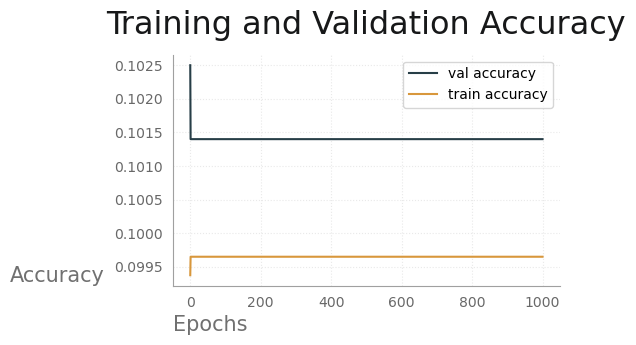

In [49]:
fig, ax = plt.subplots(figsize = (5, 3))
plt.grid(which = 'major', axis = 'both', linestyle = ':', color = '#e9e9e9')
plt.plot(validate_log, label = 'val accuracy', color = '#273E47')
plt.plot(train_log, label = 'train accuracy', color = '#D8973C')
plt.legend(loc = 'best')
xlim = ax.get_xlim()
ax.set_xlabel('Epochs', fontsize = 15, loc =
				'left').set_color('#707070')
ax.set_ylabel('Accuracy', fontsize = 15, rotation =
				'horizontal', loc = 'bottom', labelpad =
				75).set_color('#707070')
ax.set_title('Training and Validation Accuracy', fontsize = 23, pad = 15).set_color('#171819')
for pos in ['right', 'top']:
	plt.gca().spines[pos].set_visible(False)
ax.spines['bottom'].set_color('#A0A0A0')
ax.spines['left'].set_color('#A0A0A0')
ax.tick_params(axis='y', which='both', right=False,
				left=False, colors = '#686868')
ax.tick_params(axis='x', which='both', top=False,
				bottom=False, colors = '#686868')
plt.show()